<a href="https://colab.research.google.com/github/Kurooto/Python/blob/master/S_MDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
from collections import deque

In [ ]:
#データセットの用意

df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
df = df[['Date_reported', 'Country_code','Country', 'New_cases', 'New_deaths']]
df.Date_reported = pd.to_datetime(df.Date_reported)
df = df.set_index('Date_reported')

In [ ]:
#回帰分析に使うWとXの準備

code = 'JP'
number_of_day = len(df[df.Country_code == code])
W = np.ones((1,number_of_day))
row_hoge = np.arange(1, number_of_day+1)
W[0] = row_hoge
W = W.T

X_regression = (np.log(df[df.Country_code == code].New_cases+1e-1)/np.log(10)).values
X_regression.reshape(1,number_of_day)
model_lr = LinearRegression()

In [ ]:
#MDL変化統計量に出てくるRとsigma_minの計算(60日後から180日間統計を取る。)

window_size = 21
coef_norm_list = []
sigma_list = []
lag_days = 60
duration_of_sampling = 180


for i in range(lag_days, lag_days+duration_of_sampling):
  W_0 = W[i-window_size:i+window_size]
  X_0 = X_regression[i-window_size:i+window_size]
  model_lr.fit(W_0,X_0)
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(2*window_size))
  sigma = mean_squared_error(X_0, model_lr.predict(W_0))
  sigma_list.append(sigma)

  X_1 = X_regression[i-window_size:i]
  W_1 = W[i-window_size:i].reshape(window_size,1)
  model_lr.fit(W_1,X_1)
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(window_size))
  sigma = mean_squared_error(X_1, model_lr.predict(W_1))
  sigma_list.append(sigma)

  X_2 = X_regression[i:i+window_size]
  W_2 = W[i:i+window_size].reshape(window_size,1)
  model_lr.fit(W_1,X_2)
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(window_size))
  sigma = mean_squared_error(X_2, model_lr.predict(W_1))
  sigma_list.append(sigma)

coef_norm_list = np.array(coef_norm_list)
sigma_list = np.array(sigma_list)

R = np.max(coef_norm_list)
sigma_min = np.sqrt(np.min(sigma_list))

In [ ]:
#S-MDLの実装

def calculate_threshold(delta, window_size):
  return (2+1.5+delta)*np.log(2*window_size)+np.log(1/delta)

def calculate_MDL(sigma_0, sigma_1, sigma_2, n, t):
  return np.log(sigma_0**n/(sigma_1**t * sigma_2**(n-t))) - np.log(R/sigma_min**2) -np.log(math.gamma(n*0.5-1)/(math.gamma(t*0.5-1)*math.gamma((n-t)*0.5-1))) + 0.5*(n*np.log(n) - t*np.log(t) - (n-t)*np.log(n-t))

delta = 0.5
alarm_list = []
MDL_list = []
epsilon = calculate_threshold(delta, window_size)



for i in range(window_size, number_of_day-window_size+1):
  W_0 = W[i-window_size:i+window_size]
  X_0 = X_regression[i-window_size:i+window_size]
  model_lr.fit(W_0,X_0)
  sigma_0 = np.sqrt(mean_squared_error(X_0, model_lr.predict(W_0)))

  W_1 = W[i-window_size:i]
  X_1 = X_regression[i-window_size:i]
  model_lr.fit(W_1,X_1)
  sigma_1 = np.sqrt(mean_squared_error(X_1, model_lr.predict(W_1)))

  W_2 = W[i:i+window_size]
  X_2 = X_regression[i:i+window_size]
  model_lr.fit(W_1,X_2)
  sigma_2 = np.sqrt(mean_squared_error(X_2, model_lr.predict(W_1)))

  phi = calculate_MDL(sigma_0, sigma_1, sigma_2, 2*window_size, window_size)
  MDL_list.append(phi)
  if phi>epsilon:
    alarm_list.append(i)

alarm_list = np.array(alarm_list)
MDL_list = np.array(MDL_list)

15.643825653693419


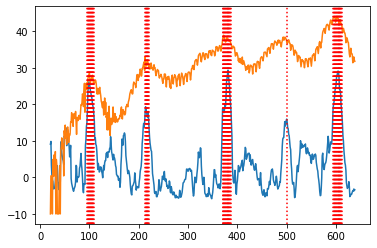

In [ ]:
#MDL変化統計量の推移のグラフ

t = np.arange(window_size, len(MDL_list)+window_size)

plt.plot(t, MDL_list)
plt.plot(t, X_regression[window_size:number_of_day-window_size+1]*10)
for i in range(len(alarm_list)):
  plt.axvline(x=alarm_list[i], color = 'red', linestyle = 'dotted')

plt.savefig('S-MDL-'+str(delta)+'.png', dpi = 300)